In [1]:
evals = list() 
ae_evals = list()

In [79]:

import utils.common
import evaluation
import importlib
import numpy as np
import time
from models.ConstraintAutoRec import ConstraintAutoRec 
import models.NeuralLogicRec
import tensorflow as tf
import pandas as pd
from models.NeuralLogicRec import item_cf, user_cf, diversity_constraint, Constraint, And, Or, Implies, Forall, Not, Equiv
importlib.reload(utils.common)
importlib.reload(evaluation)
importlib.reload(models.NeuralLogicRec)

import itertools

ml_small = utils.common.ml_small
ml_big = utils.common.movie_lens


In [44]:
popularity = np.load(ml_small['train']['item_frequency'])
pop = tf.convert_to_tensor(popularity.squeeze(), tf.float32)

constraints = list()
# constraints.append(Constraint(weight=0.25, formula=item_cf))
# constraints.append(Constraint(weight=1.0, formula=user_cf))
@tf.function
def likes_equiv(model, outputs):
    return Forall(Equiv(outputs['rec'], outputs['likes']))
constraints.append(Constraint(weight=1.0, formula=likes_equiv))
@tf.function
def novelty_constraint(model, outputs):
    return Forall(Implies(pop, Not(outputs['rec'])))
constraints.append(Constraint(weight=1.5, formula=novelty_constraint))
# constraints.append(Constraint(weight=0.75, formula=diversity_constraint))
constraints

[Constraint(weight=1.0, formula=<tensorflow.python.eager.def_function.Function object at 0x7f55e5fe3320>),
 Constraint(weight=1.5, formula=<tensorflow.python.eager.def_function.Function object at 0x7f55e5fe3048>)]

In [6]:
ev = evaluation.Evaluation(ml_small)

In [10]:
nlr_ae = models.NeuralLogicRec.NLR(ml_small['user'], ml_small['dimensions'], mode='ae', name='AE_div20sh', epochs=5, embedding_dim=40, batch_size=24, nr_hidden_layers=3, nr_item_samples = 4096, constraints=constraints)

In [11]:
nlr_ae.train(utils.common.load_dataset(ml_small), ml_small['train']['records'])
ae_evals.append(ev.evaluate_single_thread(nlr_ae))

Epoch #1 Loss at step 416: 0.1840, time: 35.926. Train P@1 0.008 P@5 0.017, Eval P@1 0.000 P@5 0.007
Epoch #2 Loss at step 416: 0.1395, time: 32.451. Train P@1 0.267 P@5 0.177, Eval P@1 0.017 P@5 0.022
Epoch #3 Loss at step 416: 0.1247, time: 32.435. Train P@1 0.300 P@5 0.270, Eval P@1 0.017 P@5 0.018
Epoch #4 Loss at step 416: 0.1203, time: 32.415. Train P@1 0.433 P@5 0.323, Eval P@1 0.042 P@5 0.027
Epoch #5 Loss at step 416: 0.1174, time: 32.453. Train P@1 0.350 P@5 0.342, Eval P@1 0.017 P@5 0.023


In [45]:
nlr_new = models.NeuralLogicRec.NLR(ml_small['user'], ml_small['dimensions'], mode='v2', name='V2_N075', epochs=12, embedding_dim=40, batch_size=64, nr_hidden_layers=3, nr_item_samples = 10_000, constraints=constraints)

In [46]:
nlr_new.train(utils.common.load_dataset(ml_small), ml_small['train']['records'])
ae_evals.append(ev.evaluate_single_thread(nlr_new))

Epoch #1 Loss at step 156: 0.1690, time: 5.818. Train P@1 0.102 P@5 0.083, Eval P@1 0.016 P@5 0.009
Epoch #2 Loss at step 156: 0.1302, time: 5.480. Train P@1 0.156 P@5 0.170, Eval P@1 0.016 P@5 0.017
Epoch #3 Loss at step 156: 0.1176, time: 5.455. Train P@1 0.242 P@5 0.236, Eval P@1 0.008 P@5 0.017
Epoch #4 Loss at step 156: 0.1114, time: 5.531. Train P@1 0.273 P@5 0.244, Eval P@1 0.031 P@5 0.016
Epoch #5 Loss at step 156: 0.1083, time: 5.465. Train P@1 0.250 P@5 0.252, Eval P@1 0.000 P@5 0.005
Epoch #6 Loss at step 156: 0.1052, time: 5.485. Train P@1 0.305 P@5 0.252, Eval P@1 0.023 P@5 0.016
Epoch #7 Loss at step 156: 0.1027, time: 5.383. Train P@1 0.250 P@5 0.287, Eval P@1 0.031 P@5 0.025
Epoch #8 Loss at step 156: 0.1007, time: 5.463. Train P@1 0.227 P@5 0.256, Eval P@1 0.055 P@5 0.027
Epoch #9 Loss at step 156: 0.0994, time: 5.337. Train P@1 0.312 P@5 0.264, Eval P@1 0.023 P@5 0.020
Epoch #10 Loss at step 156: 0.0977, time: 5.502. Train P@1 0.320 P@5 0.292, Eval P@1 0.031 P@5 0.014

In [16]:
car = models.ConstraintAutoRec.ConstraintAutoRec(ml_small['dimensions'], epochs=10, novelty_weight=0.75, diversity_weight=0.75, name='ConstraintAutoRec_N075_D075')

In [17]:
car.train(utils.common.load_dataset(ml_small), ml_small['train']['records'])
ae_evals.append(ev.evaluate_single_thread(car))

Epoch 1/10
312/312 [==============================] - 21s 67ms/step - loss: 0.2008 - accuracy: 0.0091
Epoch 2/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1854 - accuracy: 0.0107
Epoch 3/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1789 - accuracy: 0.0176
Epoch 4/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1739 - accuracy: 0.0160
Epoch 5/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1717 - accuracy: 0.0080
Epoch 6/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1690 - accuracy: 0.0094
Epoch 7/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1672 - accuracy: 0.0106
Epoch 8/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1646 - accuracy: 0.0093
Epoch 9/10
312/312 [==============================] - 6s 18ms/step - loss: 0.1630 - accuracy: 0.0086
Epoch 10/10
312/312 [==============================] - 6s 19ms/step - loss: 0.1623 - accur

In [47]:
pd.DataFrame(ae_evals)[['precision@5', 'map@1', 'map@5', 'map@10', 'diversity@5', 'diversity@10', 'epc@5', 'epc@10', 'epd@5', 'coverage@1', 'coverage@5', 'coverage@10', 'name']]

,precision@5,map@1,map@5,map@10,diversity@5,diversity@10,epc@5,epc@10,epd@5,coverage@1,coverage@5,coverage@10,name
0,0.149897,0.182238,0.100957,0.080974,0.117865,0.126351,0.768447,0.782526,0.153400,0.015413,0.039014,0.060688,NeuralLogicRec_V2_proto_N025
1,0.123614,0.149897,0.080394,0.062048,0.111950,0.122195,0.666294,0.687142,0.153573,0.006358,0.015220,0.020904,NeuralLogicRec_AE_div20sh
2,0.002053,0.000513,0.000751,0.000614,0.187922,0.188438,0.989145,0.988575,0.188831,0.033715,0.082169,0.119160,NeuralLogicRec_V2_proto_N025
3,0.184805,0.223306,0.129928,0.105793,0.118125,0.126822,0.748456,0.767970,0.151626,0.016280,0.048069,0.075812,NeuralLogicRec_V2_proto_N025
4,0.215708,0.276694,0.157783,0.130020,0.120312,0.129514,0.754307,0.771384,0.151426,0.018399,0.046720,0.073885,ConstraintAutoRec_N075_D075
5,0.155441,0.199179,0.106175,0.085204,0.122378,0.128824,0.767389,0.783314,0.153260,0.017821,0.044890,0.071669,NeuralLogicRec_V2_N025
6,0.144969,0.184805,0.097665,0.079256,0.119088,0.124859,0.754227,0.767687,0.153434,0.012812,0.034775,0.056257,NeuralLogicRec_V2_N025
7,0.155133,0.178645,0.104963,0.084111,0.120522,0.127336,0.760613,0.777232,0.153879,0.014257,0.037472,0.058954,NeuralLogicRec_V2_N025
8,0.158932,0.195072,0.108335,0.085992,0.115589,0.123444,0.754985,0.768710,0.152513,0.012427,0.032848,0.050862,NeuralLogicRec_V2_N025
9,0.158932,0.204312,0.110340,0.088842,0.116685,0.124148,0.744040,0.759248,0.151288,0.011078,0.032463,0.052403,NeuralLogicRec_V2_N001


In [59]:
ev_msd = evaluation.Evaluation(utils.common.msd_small)
msd_evals = list()

In [86]:
popularity_msd = np.load(utils.common.msd_small['train']['item_frequency'])
popularity_msd = tf.convert_to_tensor(popularity_msd.squeeze(), tf.float32)

constraints_msd = list()
# constraints.append(Constraint(weight=0.25, formula=item_cf))
# constraints_msd.append(Constraint(weight=0.75, formula=user_cf))
@tf.function
def likes_equiv(model, outputs):
    return Forall(Equiv(outputs['rec'], outputs['likes']))
constraints_msd.append(Constraint(weight=1.0, formula=likes_equiv))
@tf.function
def novelty_constraint(model, outputs):
    return Forall(Implies(popularity_msd, Not(outputs['rec'])))
constraints_msd.append(Constraint(weight=0.1, formula=novelty_constraint))
# constraints.append(Constraint(weight=0.75, formula=diversity_constraint))
constraints_msd

[Constraint(weight=1.0, formula=<tensorflow.python.eager.def_function.Function object at 0x7f55e30a5be0>),
 Constraint(weight=0.1, formula=<tensorflow.python.eager.def_function.Function object at 0x7f55e590ef28>)]

In [87]:
nlr_msd = models.NeuralLogicRec.NLR(utils.common.msd_small['user'], utils.common.msd_small['dimensions'], mode='v2', name='V2_N05', epochs=12, embedding_dim=40, batch_size=32, nr_hidden_layers=3, nr_item_samples = 10_000, constraints=constraints_msd)
nlr_msd.train(utils.common.load_dataset(utils.common.msd_small), utils.common.msd_small['train']['records'])
msd_evals.append(ev_msd.evaluate_single_thread(nlr_msd))

Epoch #1 Loss at step 312: 0.2121, time: 8.266. Train P@1 0.078 P@5 0.108, Eval P@1 0.000 P@5 0.005
Epoch #2 Loss at step 312: 0.1807, time: 7.890. Train P@1 0.156 P@5 0.162, Eval P@1 0.031 P@5 0.008
Epoch #3 Loss at step 312: 0.1673, time: 7.619. Train P@1 0.180 P@5 0.153, Eval P@1 0.000 P@5 0.011
Epoch #4 Loss at step 312: 0.1575, time: 7.798. Train P@1 0.250 P@5 0.222, Eval P@1 0.008 P@5 0.014
Epoch #5 Loss at step 312: 0.1494, time: 7.908. Train P@1 0.203 P@5 0.213, Eval P@1 0.016 P@5 0.017
Epoch #6 Loss at step 312: 0.1428, time: 7.873. Train P@1 0.312 P@5 0.255, Eval P@1 0.023 P@5 0.013
Epoch #7 Loss at step 312: 0.1372, time: 7.918. Train P@1 0.188 P@5 0.186, Eval P@1 0.016 P@5 0.011
Epoch #8 Loss at step 312: 0.1327, time: 7.734. Train P@1 0.227 P@5 0.184, Eval P@1 0.016 P@5 0.011
Epoch #9 Loss at step 312: 0.1290, time: 7.869. Train P@1 0.312 P@5 0.241, Eval P@1 0.008 P@5 0.014
Epoch #10 Loss at step 312: 0.1258, time: 8.251. Train P@1 0.289 P@5 0.211, Eval P@1 0.016 P@5 0.011

In [69]:
# car_msd = models.ConstraintAutoRec.ConstraintAutoRec(utils.common.msd_small['dimensions'], epochs=10, novelty_weight=0.75, diversity_weight=0.75, name='ConstraintAutoRec_N075_D075')
# car_msd.train(utils.common.load_dataset(utils.common.msd_small), utils.common.msd_small['train']['records'])
msd_evals.append(ev_msd.evaluate_single_thread(car_msd))

In [88]:
pd.DataFrame(msd_evals)[['precision@5', 'map@1', 'map@5', 'map@10', 'diversity@5', 'diversity@10', 'epc@5', 'epc@10', 'epd@5', 'coverage@1', 'coverage@5', 'coverage@10', 'name']]

,precision@5,map@1,map@5,map@10,diversity@5,diversity@10,epc@5,epc@10,epd@5,coverage@1,coverage@5,coverage@10,name
0,0.061664,0.074528,0.037029,0.027715,0.235742,0.242824,0.913901,0.920919,0.285435,0.028754,0.080602,0.132002,NeuralLogicRec_V2_N02
1,0.066667,0.091373,0.041631,0.031332,0.241578,0.246088,0.909912,0.917794,0.285638,0.031138,0.088796,0.145113,NeuralLogicRec_V2_N02
2,0.065646,0.092905,0.040566,0.029669,0.247278,0.253262,0.909916,0.918190,0.287365,0.030095,0.093713,0.153308,NeuralLogicRec_V2_N01
3,0.090658,0.117917,0.056989,0.043398,0.222874,0.229208,0.923651,0.930047,0.277672,0.049911,0.146007,0.221246,ConstraintAutoRec_N075_D075
4,0.059316,0.071975,0.034983,0.026968,0.240088,0.246479,0.908819,0.916793,0.285877,0.027265,0.088796,0.142431,NeuralLogicRec_V2_N05
5,0.061970,0.088821,0.038286,0.028529,0.240524,0.245170,0.908965,0.917291,0.285818,0.026520,0.081198,0.135578,NeuralLogicRec_V2_N05
6,0.069729,0.089842,0.043261,0.032484,0.234280,0.240327,0.916622,0.923477,0.280781,0.035459,0.108164,0.179380,NeuralLogicRec_V2_N05
7,0.069423,0.080143,0.040838,0.030268,0.247164,0.250147,0.923672,0.929335,0.288958,0.040375,0.133790,0.212902,NeuralLogicRec_V2_N05
8,0.059010,0.083716,0.036610,0.027473,0.225829,0.236378,0.918709,0.925670,0.280927,0.035012,0.101907,0.159714,NeuralLogicRec_V2_N05


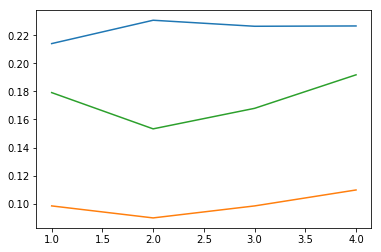

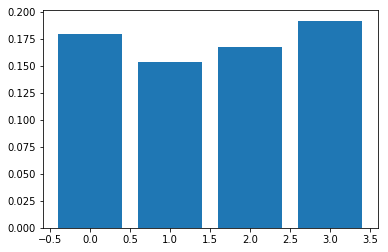

In [175]:
eval_data = pd.DataFrame(ae_evals[-8:])
eval_data = eval_data.sort_values(by='epochs_trained')
import matplotlib.pyplot as plt
plt.plot(eval_data['epochs_trained'], eval_data['diversity@5'])
plt.plot(eval_data['epochs_trained'], eval_data['map@5'])
plt.plot(eval_data['epochs_trained'], eval_data['map@1'])
plt.show()
plt.bar(eval_data.index, eval_data['map@1'])
plt.show()

In [ ]:
np.array([])

In [4]:
tf.version.VERSION

'2.0.0-rc0'